# Implementing a Neural Network for CIFAR dataset - Convolutional Networks

Remember ex2? Now, you will try to improve it by using CNNs. Using conovolutioal layers when working with images should improve your results.

All the code is written for you (loading images, training loop...), you shoiuld come up with a CNN from your own.

As usual, you can try to add also augmentations, or other advanced tools you learnt (weight decay, learning rate, regularizations...)


## Loading CIFAR dataset

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])
# transform_train = transforms.Compose(
#     [transforms.ToTensor()])
transform_val = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

100%|██████████| 170498071/170498071 [00:13<00:00, 12692460.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

inputs: <class 'torch.Tensor'> torch.Size([16, 3, 32, 32])
inputs[0].T torch.Size([32, 32, 3])


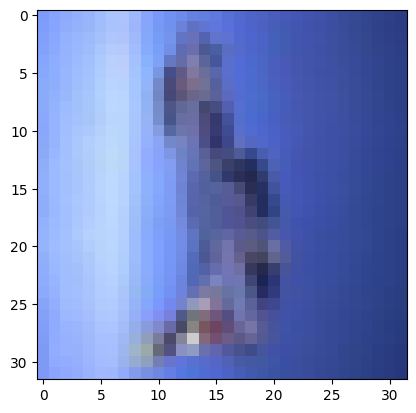

In [ ]:
import matplotlib.pyplot as plt
print('inputs:', type(inputs), inputs.shape)
print('inputs[0].T', inputs[0].T.shape)
plt.imshow(inputs[0].T)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

inputs: torch.Size([16, 3, 32, 32])
out: torch.Size([3, 70, 274])


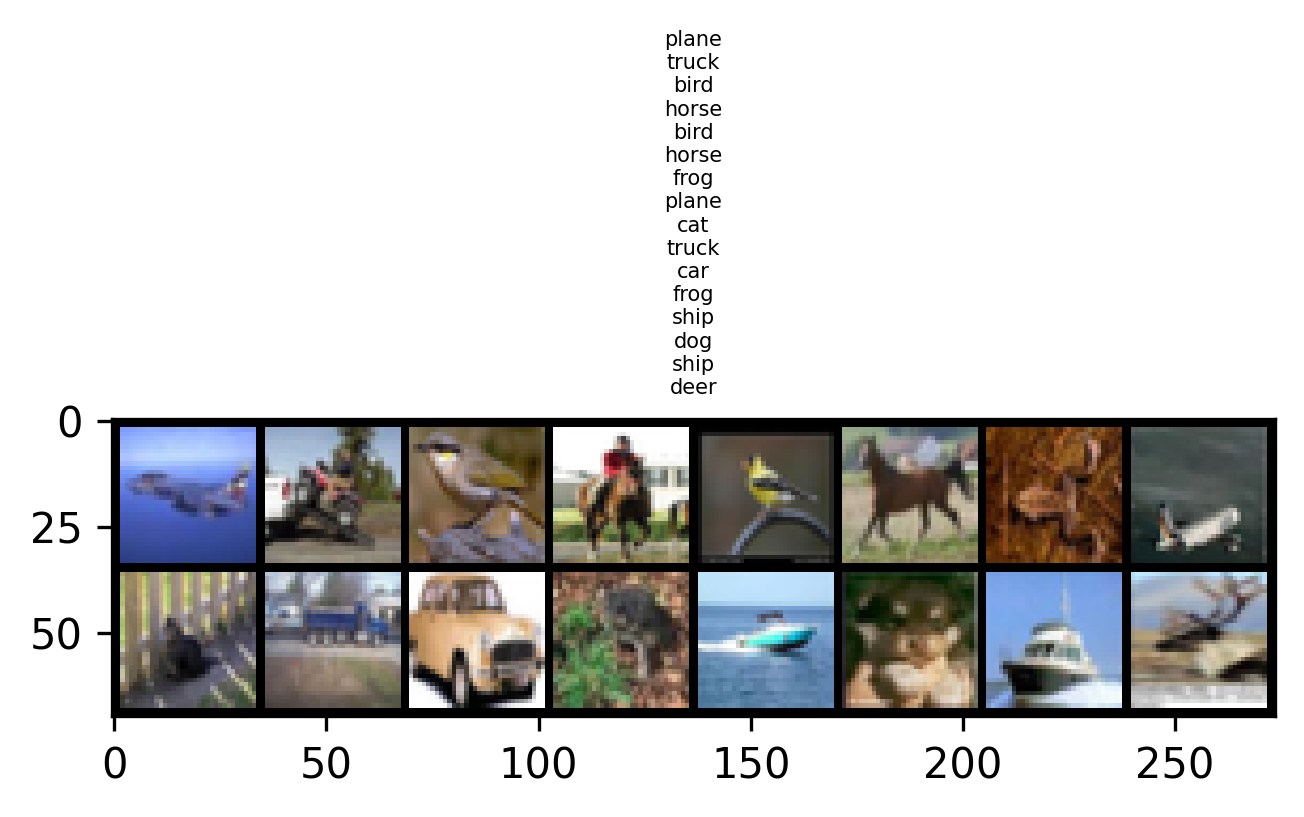

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
print('inputs:', inputs.shape)
print('out:', out.shape)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## CNN (100 points)

You should define a CNN

### Defining three CNNs

#### NeuralNetwork_1

Simple network, using 3 conv. layers

In [ ]:
class NeuralNetwork_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # For CIFAR - 3 input channels
            nn.Conv2d(3, 32, (3,3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3)),
            nn.ReLU(),
            nn.Flatten(),
            # CIFAR input is 32X32, and 6 pixels were removed in the 3 Conv layers
            nn.Linear(128*(32-6)*(32-6), 10)
        )

    def forward(self, x):
        return self.model(x)

#### NeuralNetwork_2

Simple network, using 4 conv. layers and diving the network to feature extractor and classifier

In [ ]:
class NeuralNetwork_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, (3,3)), # Dimensions get smaller by 2
            nn.ReLU(),
            nn.Conv2d(32, 64, (3,3)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3,3)),
            nn.ReLU(),
            nn.Conv2d(128, 256, (3,3)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # CIFAR input is 32X32, and 8 pixels were removed in 4 Conv layers
        # Last layer output was 256
        n_channels = 256*(32-8)*(32-8)

        self.classifier = nn.Sequential(
            nn.Linear(n_channels, 10)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

#### NeuralNetwork_3

Using 5 conv. layers and max pooling, and 3 linear layers with dropouts


In [ ]:
class NeuralNetwork_3(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # Dimensions get 2 times smaller
            nn.Conv2d(32, 64, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, (3,3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, (3,3), padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # CIFAR input is 32X32, and 3 max pooling layers were used
        # Last layer output was 512
        n_channels = int(512*(32/2/2/2)*(32/2/2/2))

        self.classifier = nn.Sequential(
            nn.Linear(n_channels, 200),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(100, 10))

    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.classifier(features)
        return output

### Defining utility functions to tests several networks easily

In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


A function to describe the model

In [ ]:
from torchsummary import summary

def describe_model(nn_class, silent=False):
    model = nn_class().to(device)
    if not silent:
        print(model)
        summary(model.to(device), (3, 32, 32))
    return model

A function to define the loss function, the optimizer and the schedular

In [ ]:
def define_hyperparams(model, lr=0.01, adam=False, reg=False):
    # If a GPU is available, make the model use it
    model = model.to(device)

    # For a multi-class problem, you'd usually prefer CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss()

    # Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.01 and momentum
    if adam: # Adam
        optimizer_ft = optim.Adam(model.parameters(), lr=1e-3)
    elif reg: # SGD with L2 regulrization
        optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
    else: # SGD - the default
        optimizer_ft = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    return model, criterion, optimizer_ft, exp_lr_scheduler

Using the given train function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, silent=False):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        if not silent:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) #
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if not silent:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        if not silent:
            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

The given plot convergence function

In [ ]:
vgg


### Using the models

In [ ]:
num_epochs = 10

#### Using NeuralNetwork_1

In [ ]:
model_1 = describe_model(NeuralNetwork_1)

NeuralNetwork_1(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=86528, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 128, 26, 26]          73,856
              ReLU-6          [-1, 128, 26, 26]               0
           Flatten-7                [-1, 86528]               0
            Linear-8                   [-1, 10]

Defining the hyper-aprameters

In [ ]:
model_1, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_1, lr=0.01)

Training

In [ ]:
model_1, dict_res_1 = train_model(model_1,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.7416 Acc: 0.3777
val Loss: 1.4837 Acc: 0.4763

Epoch 1/9
----------
train Loss: 1.3935 Acc: 0.5038
val Loss: 1.3140 Acc: 0.5310

Epoch 2/9
----------
train Loss: 1.2050 Acc: 0.5760
val Loss: 1.1505 Acc: 0.5928

Epoch 3/9
----------
train Loss: 1.0553 Acc: 0.6290
val Loss: 1.0327 Acc: 0.6384

Epoch 4/9
----------
train Loss: 0.9509 Acc: 0.6702
val Loss: 0.9962 Acc: 0.6525

Epoch 5/9
----------
train Loss: 0.8684 Acc: 0.6980
val Loss: 0.9652 Acc: 0.6656

Epoch 6/9
----------
train Loss: 0.7983 Acc: 0.7255
val Loss: 0.9192 Acc: 0.6792

Epoch 7/9
----------
train Loss: 0.6380 Acc: 0.7869
val Loss: 0.8602 Acc: 0.7062

Epoch 8/9
----------
train Loss: 0.6080 Acc: 0.7965
val Loss: 0.8540 Acc: 0.7041

Epoch 9/9
----------
train Loss: 0.5912 Acc: 0.8025
val Loss: 0.8538 Acc: 0.7088

Training complete in 2m 30s
Best val Acc: 0.708800


Plotting

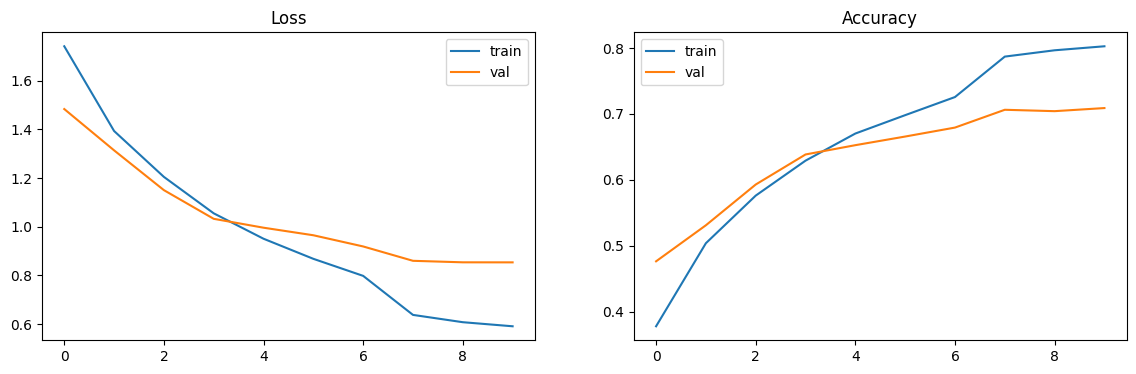

In [ ]:
plot_convergence(dict_res_1, num_epochs)

#### Using NeuralNetwork_2

In [ ]:
model_2 = describe_model(NeuralNetwork_2)

NeuralNetwork_2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=147456, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 128, 26, 26]          73,856
              ReLU-6          [-1, 128, 26, 26]      

In [ ]:
model_2, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_2, lr=0.02)

Training

In [ ]:
model_2, dict_res_2 = train_model(model_2,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.8769 Acc: 0.3197
val Loss: 1.5655 Acc: 0.4313

Epoch 1/9
----------
train Loss: 1.4262 Acc: 0.4884
val Loss: 1.2379 Acc: 0.5618

Epoch 2/9
----------
train Loss: 1.1605 Acc: 0.5926
val Loss: 1.0645 Acc: 0.6272

Epoch 3/9
----------
train Loss: 0.9830 Acc: 0.6579
val Loss: 0.9876 Acc: 0.6501

Epoch 4/9
----------
train Loss: 0.8568 Acc: 0.7017
val Loss: 0.9944 Acc: 0.6622

Epoch 5/9
----------
train Loss: 0.7600 Acc: 0.7387
val Loss: 0.9034 Acc: 0.6890

Epoch 6/9
----------
train Loss: 0.6549 Acc: 0.7771
val Loss: 0.9222 Acc: 0.6875

Epoch 7/9
----------
train Loss: 0.4379 Acc: 0.8581
val Loss: 0.8597 Acc: 0.7202

Epoch 8/9
----------
train Loss: 0.3820 Acc: 0.8786
val Loss: 0.8762 Acc: 0.7220

Epoch 9/9
----------
train Loss: 0.3474 Acc: 0.8888
val Loss: 0.8910 Acc: 0.7245

Training complete in 2m 54s
Best val Acc: 0.724500


Plotting

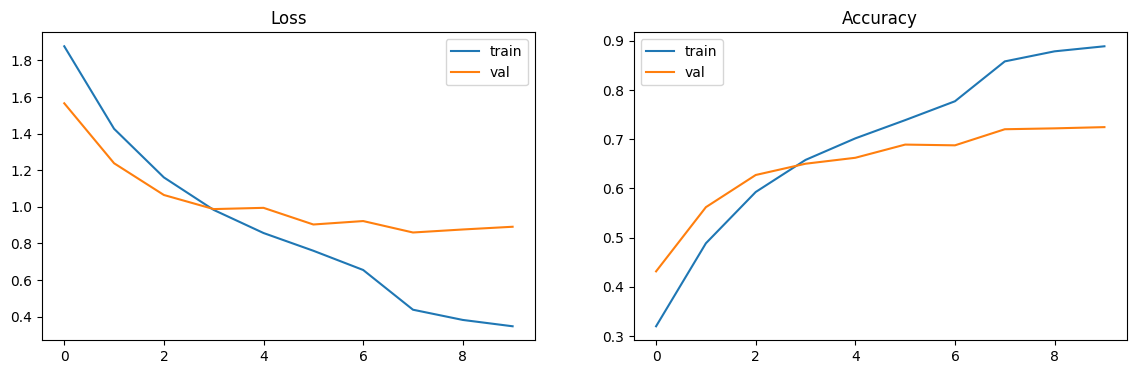

In [ ]:
plot_convergence(dict_res_2, num_epochs)

#### Using NeuralNetwork_3

In [ ]:
model_3 = describe_model(NeuralNetwork_3)

NeuralNetwork_3(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=8192, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=200, out_fea

In [ ]:
model_3, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_3, lr=0.05)

Training

In [ ]:
model_3, dict_res_3 = train_model(model_3,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.3019 Acc: 0.1053
val Loss: 2.3029 Acc: 0.1000

Epoch 1/9
----------
train Loss: 2.2155 Acc: 0.1499
val Loss: 1.9130 Acc: 0.2682

Epoch 2/9
----------
train Loss: 1.7281 Acc: 0.3451
val Loss: 1.5774 Acc: 0.4175

Epoch 3/9
----------
train Loss: 1.4361 Acc: 0.4790
val Loss: 1.2820 Acc: 0.5425

Epoch 4/9
----------
train Loss: 1.2190 Acc: 0.5664
val Loss: 1.1262 Acc: 0.5915

Epoch 5/9
----------
train Loss: 1.0504 Acc: 0.6333
val Loss: 1.0173 Acc: 0.6369

Epoch 6/9
----------
train Loss: 0.9337 Acc: 0.6771
val Loss: 0.9173 Acc: 0.6860

Epoch 7/9
----------
train Loss: 0.6834 Acc: 0.7659
val Loss: 0.7593 Acc: 0.7373

Epoch 8/9
----------
train Loss: 0.6155 Acc: 0.7893
val Loss: 0.7324 Acc: 0.7556

Epoch 9/9
----------
train Loss: 0.5730 Acc: 0.8051
val Loss: 0.7191 Acc: 0.7584

Training complete in 2m 13s
Best val Acc: 0.758400


Plotting

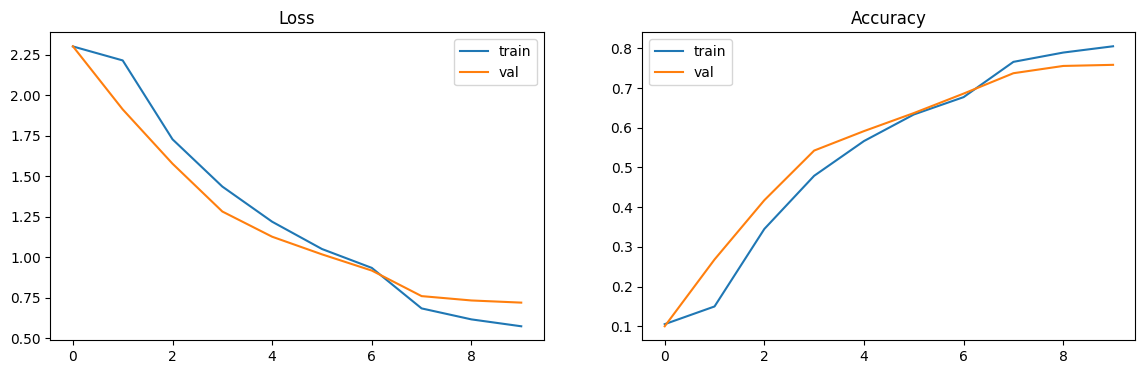

In [ ]:
plot_convergence(dict_res_3, num_epochs)

#### Use NeuralNetwork_3 with regulraization

In [ ]:
model_3_1 = describe_model(NeuralNetwork_3, silent=True)

In [ ]:
model_3_1, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_3_1, lr=0.05, reg=True)

In [ ]:
model_3_1, dict_res_3_1 = train_model(model_3_1,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/14
----------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

train Loss: 2.2789 Acc: 0.1200
val Loss: 2.0892 Acc: 0.2045

Epoch 1/14
----------


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60><function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
AssertionError
: can only test a child process
  File "/usr/lib/pytho

train Loss: 1.8212 Acc: 0.3116
val Loss: 1.5664 Acc: 0.4258

Epoch 2/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 1.4452 Acc: 0.4717
val Loss: 1.2549 Acc: 0.5256

Epoch 3/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 1.2102 Acc: 0.5669
val Loss: 1.0865 Acc: 0.6185

Epoch 4/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 1.0295 Acc: 0.6419
val Loss: 0.9508 Acc: 0.6741

Epoch 5/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.8839 Acc: 0.6993
val Loss: 0.8643 Acc: 0.7008

Epoch 6/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorself._shutdown_workers(): 
can only test a child process  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.7827 Acc: 0.7318
val Loss: 0.9436 Acc: 0.6836

Epoch 7/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.5673 Acc: 0.8061
val Loss: 0.6773 Acc: 0.7743

Epoch 8/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.4944 Acc: 0.8311
val Loss: 0.6622 Acc: 0.7803

Epoch 9/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: 
can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.4520 Acc: 0.8460
val Loss: 0.6551 Acc: 0.7851

Epoch 10/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.4164 Acc: 0.8596
val Loss: 0.6582 Acc: 0.7866

Epoch 11/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>    
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
:     can only test a child process
if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.3822 Acc: 0.8718
val Loss: 0.6590 Acc: 0.7910

Epoch 12/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

train Loss: 0.3452 Acc: 0.8840
val Loss: 0.6704 Acc: 0.7907

Epoch 13/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.3135 Acc: 0.8941
val Loss: 0.6794 Acc: 0.7929

Epoch 14/14
----------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fea54e9ea60>

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
AssertionError    self._shutdown_workers()
: can only test a child process
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

train Loss: 0.2662 Acc: 0.9150
val Loss: 0.6731 Acc: 0.7972

Training complete in 3m 33s
Best val Acc: 0.797200


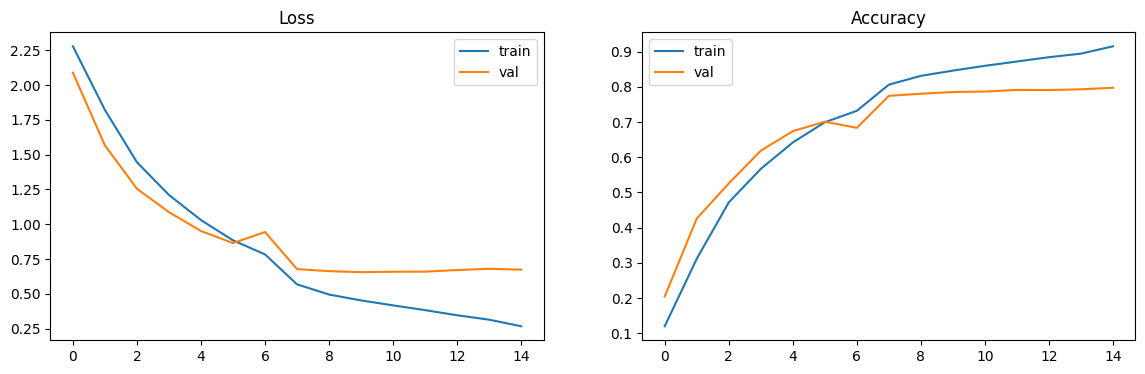

In [ ]:
plot_convergence(dict_res_3_1, num_epochs)

#### Use NeuralNetwork_3 with the Adam optimizer

In [ ]:
model_3_2 = describe_model(NeuralNetwork_3, silent=True)

In [ ]:
model_3_2, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_3_2, lr=0.05, adam=True)

In [ ]:
model_3_2, dict_res_3_2 = train_model(model_3_2,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 1.8220 Acc: 0.3064
val Loss: 1.4714 Acc: 0.4524

Epoch 1/9
----------
train Loss: 1.3732 Acc: 0.4961
val Loss: 1.1881 Acc: 0.5682

Epoch 2/9
----------
train Loss: 1.1714 Acc: 0.5837
val Loss: 1.0857 Acc: 0.6148

Epoch 3/9
----------
train Loss: 1.0420 Acc: 0.6327
val Loss: 0.9439 Acc: 0.6692

Epoch 4/9
----------
train Loss: 0.9406 Acc: 0.6736
val Loss: 0.8886 Acc: 0.6915

Epoch 5/9
----------
train Loss: 0.8644 Acc: 0.7007
val Loss: 0.9020 Acc: 0.6889

Epoch 6/9
----------
train Loss: 0.7948 Acc: 0.7284
val Loss: 0.8043 Acc: 0.7208

Epoch 7/9
----------
train Loss: 0.6487 Acc: 0.7788
val Loss: 0.7329 Acc: 0.7514

Epoch 8/9
----------
train Loss: 0.6123 Acc: 0.7893
val Loss: 0.7271 Acc: 0.7569

Epoch 9/9
----------
train Loss: 0.5907 Acc: 0.7987
val Loss: 0.7292 Acc: 0.7581

Training complete in 2m 14s
Best val Acc: 0.758100


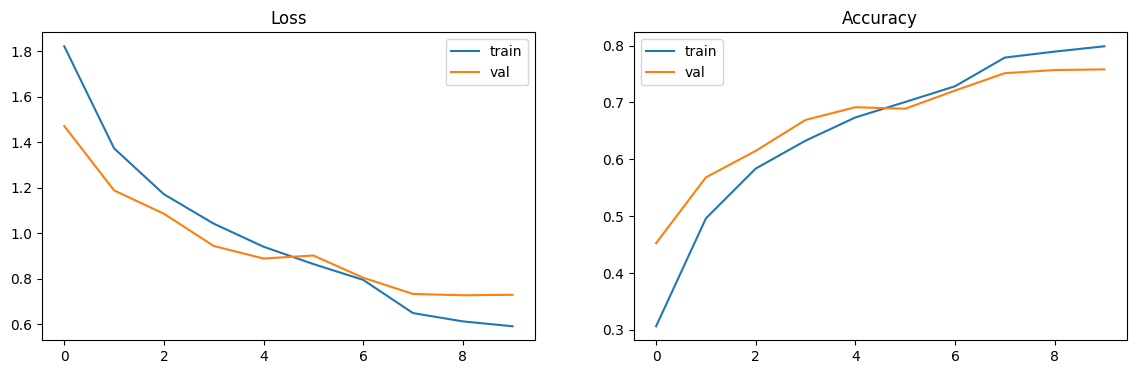

In [ ]:
plot_convergence(dict_res_3_2, num_epochs)

#### Comparison

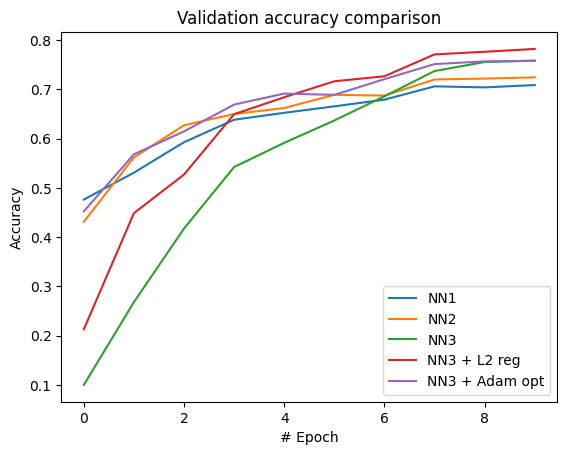

In [ ]:
plt.plot(dict_res_1['val'][1], label='NN1')
plt.plot(dict_res_2['val'][1], label='NN2')
plt.plot(dict_res_3['val'][1], label='NN3')
plt.plot(dict_res_3_1['val'][1], label='NN3 + L2 reg')
plt.plot(dict_res_3_2['val'][1], label='NN3 + Adam opt')
plt.title('Validation accuracy comparison')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend()

We will continue with the NN3 model with the regularization

### Optimizing the learning rate

In [ ]:
def train_and_get_last_acc(lr, num_epochs=10):
    model = describe_model(NeuralNetwork_3, silent=True)
    model, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model, lr=lr, reg=True)
    model, dict_res = train_model(model,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs,
                       silent=True)

    last_acc = dict_res['val'][1][-1]
    return last_acc

In [ ]:
losses = []
lr_range = np.logspace(-1, -2, num=7)
for lr in lr_range:
    print('Learning rate:', lr)
    losses.append(train_and_get_last_acc(lr=lr, num_epochs=10))
    print('-'*30)


Learning rate: 0.1
Training complete in 2m 24s
Best val Acc: 0.122700
------------------------------
Learning rate: 0.06812920690579612
Training complete in 2m 14s
Best val Acc: 0.748200
------------------------------
Learning rate: 0.046415888336127795
Training complete in 2m 13s
Best val Acc: 0.783300
------------------------------
Learning rate: 0.03162277660168379
Training complete in 2m 12s
Best val Acc: 0.783800
------------------------------
Learning rate: 0.021544346900318846
Training complete in 2m 12s
Best val Acc: 0.750600
------------------------------
Learning rate: 0.014677992676220698
Training complete in 2m 13s
Best val Acc: 0.703100
------------------------------
Learning rate: 0.01
Training complete in 2m 12s
Best val Acc: 0.616700
------------------------------


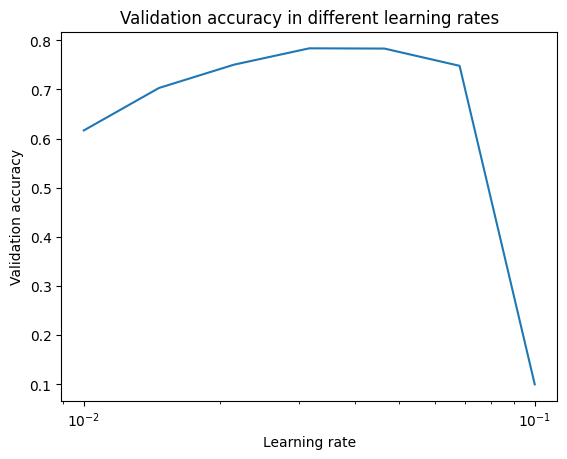

In [ ]:
plt.plot(lr_range, losses)
plt.xscale("log")
plt.xlabel('Learning rate')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy in different learning rates');

### Adding augemntation

In [ ]:
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406] # RBG
stds = [0.229, 0.224, 0.225]

num_epochs = 15

#### Adding only normalization

In [ ]:
# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(), # Applying random horizontal flip
     #transforms.RandomRotation(0.5), # Applying random rotation
     #transforms.ColorJitter(brightness=.1, hue=.1), # Applying color jitter
     transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders_2 = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


Epoch 0/14
----------
train Loss: 1.9482 Acc: 0.2609
val Loss: 1.5724 Acc: 0.4096

Epoch 1/14
----------
train Loss: 1.3927 Acc: 0.4910
val Loss: 1.2188 Acc: 0.5619

Epoch 2/14
----------
train Loss: 1.1007 Acc: 0.6122
val Loss: 0.9899 Acc: 0.6563

Epoch 3/14
----------
train Loss: 0.9079 Acc: 0.6881
val Loss: 0.8769 Acc: 0.6959

Epoch 4/14
----------
train Loss: 0.7791 Acc: 0.7329
val Loss: 0.7616 Acc: 0.7411

Epoch 5/14
----------
train Loss: 0.6797 Acc: 0.7691
val Loss: 0.7106 Acc: 0.7608

Epoch 6/14
----------
train Loss: 0.6105 Acc: 0.7921
val Loss: 0.6802 Acc: 0.7709

Epoch 7/14
----------
train Loss: 0.4169 Acc: 0.8589
val Loss: 0.5994 Acc: 0.8009

Epoch 8/14
----------
train Loss: 0.3655 Acc: 0.8766
val Loss: 0.5927 Acc: 0.8058

Epoch 9/14
----------
train Loss: 0.3293 Acc: 0.8896
val Loss: 0.5974 Acc: 0.8066

Epoch 10/14
----------
train Loss: 0.3005 Acc: 0.8994
val Loss: 0.6006 Acc: 0.8076

Epoch 11/14
----------
train Loss: 0.2663 Acc: 0.9116
val Loss: 0.6078 Acc: 0.8087

Ep

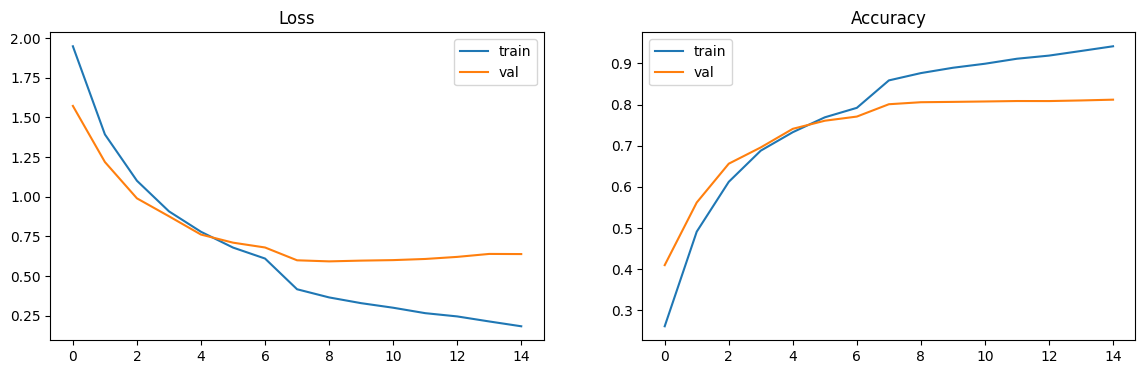

In [ ]:
model_aug_1 = describe_model(NeuralNetwork_3, silent=True)
model_aug_1, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_aug_1, lr=0.03, reg=True)
model_aug_1, dict_res_aug_1 = train_model(model_aug_1,
                    dataloaders_2,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)
plot_convergence(dict_res_aug_1, num_epochs)

#### Adding normalization and color jitter

In [ ]:
# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(), # Applying random horizontal flip
     #transforms.RandomRotation(0.5), # Applying random rotation
     transforms.ColorJitter(brightness=.1, hue=.1), # Applying color jitter
     transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders_2 = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


Epoch 0/14
----------
train Loss: 2.0024 Acc: 0.2375
val Loss: 1.5385 Acc: 0.4011

Epoch 1/14
----------
train Loss: 1.4305 Acc: 0.4694
val Loss: 1.2376 Acc: 0.5621

Epoch 2/14
----------
train Loss: 1.0987 Acc: 0.6088
val Loss: 0.9515 Acc: 0.6767

Epoch 3/14
----------
train Loss: 0.9136 Acc: 0.6831
val Loss: 0.8422 Acc: 0.7120

Epoch 4/14
----------
train Loss: 0.7877 Acc: 0.7312
val Loss: 0.7602 Acc: 0.7436

Epoch 5/14
----------
train Loss: 0.7019 Acc: 0.7598
val Loss: 0.6945 Acc: 0.7596

Epoch 6/14
----------
train Loss: 0.6323 Acc: 0.7853
val Loss: 0.6826 Acc: 0.7744

Epoch 7/14
----------
train Loss: 0.4402 Acc: 0.8511
val Loss: 0.5863 Acc: 0.8053

Epoch 8/14
----------
train Loss: 0.3883 Acc: 0.8680
val Loss: 0.5775 Acc: 0.8095

Epoch 9/14
----------
train Loss: 0.3579 Acc: 0.8796
val Loss: 0.5706 Acc: 0.8137

Epoch 10/14
----------
train Loss: 0.3282 Acc: 0.8893
val Loss: 0.5811 Acc: 0.8124

Epoch 11/14
----------
train Loss: 0.3043 Acc: 0.8981
val Loss: 0.5928 Acc: 0.8167

Ep

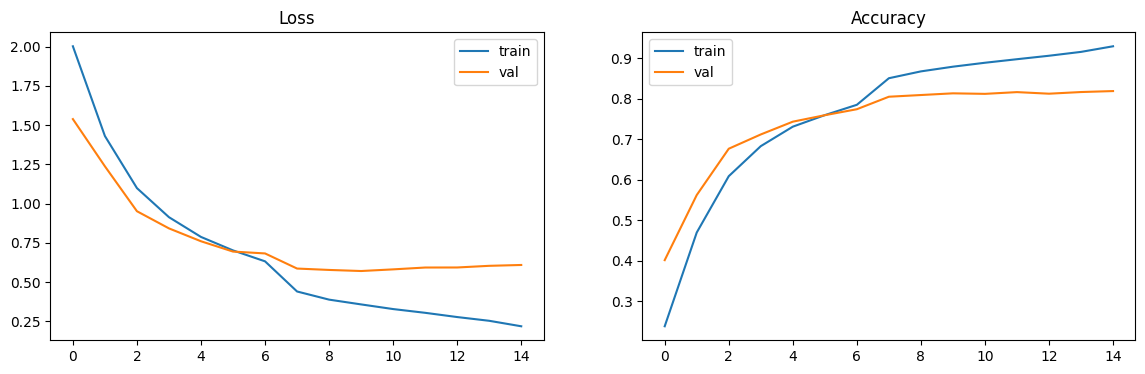

In [ ]:
model_aug_2 = describe_model(NeuralNetwork_3, silent=True)
model_aug_2, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_aug_2, lr=0.03, reg=True)
model_aug_2, dict_res_aug_2 = train_model(model_aug_2,
                    dataloaders_2,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)
plot_convergence(dict_res_aug_2, num_epochs)

#### Adding normalization and random rotation

In [ ]:
# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(), # Applying random horizontal flip
     transforms.RandomRotation(0.5), # Applying random rotation
     #transforms.ColorJitter(brightness=.1, hue=.1), # Applying color jitter
     transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders_2 = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


Epoch 0/14
----------
train Loss: 1.9752 Acc: 0.2510
val Loss: 1.5282 Acc: 0.4336

Epoch 1/14
----------
train Loss: 1.3796 Acc: 0.4936
val Loss: 1.2451 Acc: 0.5603

Epoch 2/14
----------
train Loss: 1.0844 Acc: 0.6176
val Loss: 0.9356 Acc: 0.6721

Epoch 3/14
----------
train Loss: 0.8960 Acc: 0.6916
val Loss: 0.8163 Acc: 0.7206

Epoch 4/14
----------
train Loss: 0.7659 Acc: 0.7409
val Loss: 0.7928 Acc: 0.7251

Epoch 5/14
----------
train Loss: 0.6840 Acc: 0.7669
val Loss: 0.7371 Acc: 0.7494

Epoch 6/14
----------
train Loss: 0.6180 Acc: 0.7909
val Loss: 0.6908 Acc: 0.7682

Epoch 7/14
----------
train Loss: 0.4287 Acc: 0.8554
val Loss: 0.5753 Acc: 0.8064

Epoch 8/14
----------
train Loss: 0.3694 Acc: 0.8773
val Loss: 0.5735 Acc: 0.8124

Epoch 9/14
----------
train Loss: 0.3326 Acc: 0.8889
val Loss: 0.5785 Acc: 0.8115

Epoch 10/14
----------
train Loss: 0.3051 Acc: 0.8981
val Loss: 0.5785 Acc: 0.8158

Epoch 11/14
----------
train Loss: 0.2816 Acc: 0.9065
val Loss: 0.5905 Acc: 0.8150

Ep

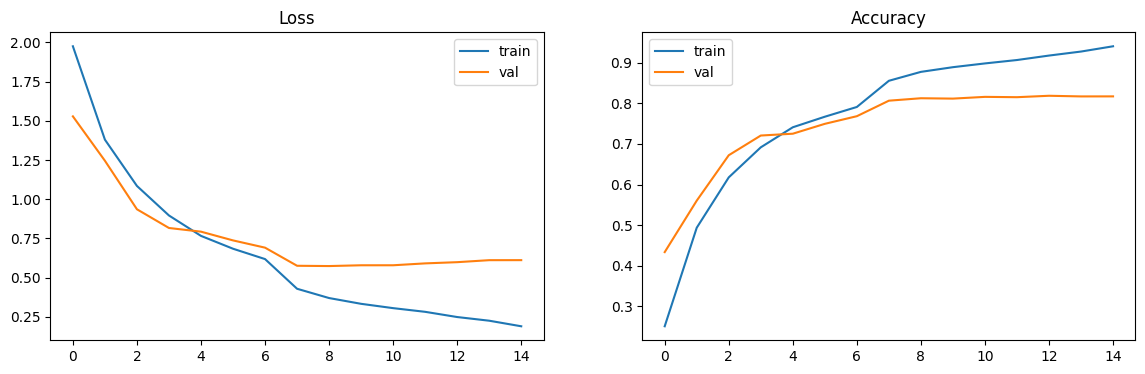

In [ ]:
model_aug_3 = describe_model(NeuralNetwork_3, silent=True)
model_aug_3, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_aug_3, lr=0.03, reg=True)
model_aug_3, dict_res_aug_3 = train_model(model_aug_3,
                    dataloaders_2,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)
plot_convergence(dict_res_aug_3, num_epochs)

#### Adding normalization, random rotation and color jitter

In [ ]:
# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(), # Applying random horizontal flip
     transforms.RandomRotation(0.5), # Applying random rotation
     transforms.ColorJitter(brightness=.1, hue=.1), # Applying color jitter
     transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization
transform_val = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(means, stds)]) # Applying normalization

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders_2 = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

Files already downloaded and verified
Files already downloaded and verified


Epoch 0/14
----------
train Loss: 1.9386 Acc: 0.2644
val Loss: 1.5074 Acc: 0.4411

Epoch 1/14
----------
train Loss: 1.3661 Acc: 0.5016
val Loss: 1.1483 Acc: 0.5855

Epoch 2/14
----------
train Loss: 1.0703 Acc: 0.6241
val Loss: 0.9446 Acc: 0.6698

Epoch 3/14
----------
train Loss: 0.9038 Acc: 0.6903
val Loss: 0.8051 Acc: 0.7280

Epoch 4/14
----------
train Loss: 0.7744 Acc: 0.7352
val Loss: 0.7582 Acc: 0.7424

Epoch 5/14
----------
train Loss: 0.6888 Acc: 0.7655
val Loss: 0.7121 Acc: 0.7611

Epoch 6/14
----------
train Loss: 0.6206 Acc: 0.7887
val Loss: 0.7178 Acc: 0.7553

Epoch 7/14
----------
train Loss: 0.4429 Acc: 0.8505
val Loss: 0.5930 Acc: 0.8047

Epoch 8/14
----------
train Loss: 0.3874 Acc: 0.8683
val Loss: 0.5868 Acc: 0.8050

Epoch 9/14
----------
train Loss: 0.3572 Acc: 0.8788
val Loss: 0.5822 Acc: 0.8082

Epoch 10/14
----------
train Loss: 0.3305 Acc: 0.8895
val Loss: 0.5790 Acc: 0.8124

Epoch 11/14
----------
train Loss: 0.3012 Acc: 0.8989
val Loss: 0.5960 Acc: 0.8110

Ep

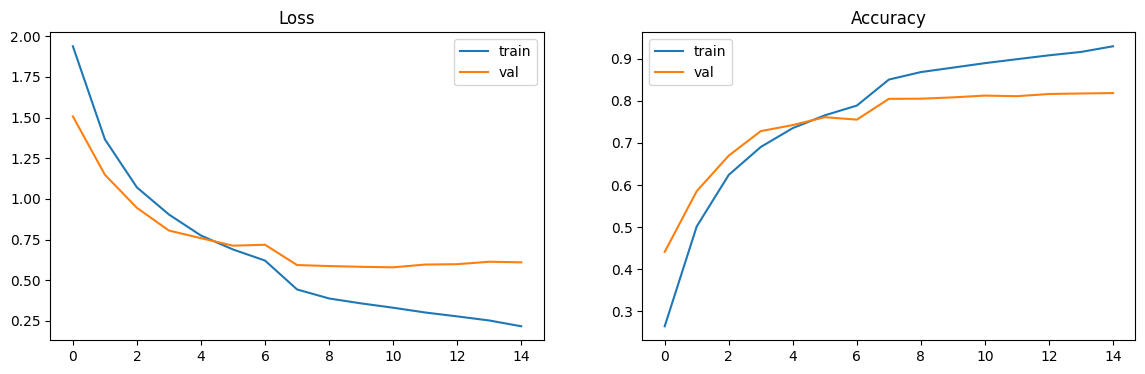

In [ ]:
model_aug_4 = describe_model(NeuralNetwork_3, silent=True)
model_aug_4, criterion, optimizer_ft, exp_lr_scheduler = define_hyperparams(model_aug_4, lr=0.03, reg=True)
model_aug_4, dict_res_aug_4 = train_model(model_aug_4,
                    dataloaders_2,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)
plot_convergence(dict_res_aug_4, num_epochs)

#### Comparison

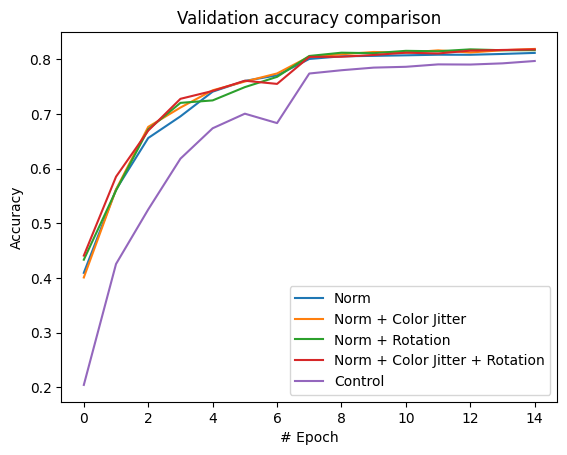

In [ ]:
plt.plot(dict_res_aug_1['val'][1], label='Norm')
plt.plot(dict_res_aug_2['val'][1], label='Norm + Color Jitter')
plt.plot(dict_res_aug_3['val'][1], label='Norm + Rotation')
plt.plot(dict_res_aug_4['val'][1], label='Norm + Color Jitter + Rotation')
plt.plot(dict_res_3_1['val'][1], label='Control')
plt.title('Validation accuracy comparison')
plt.xlabel('# Epoch')
plt.ylabel('Accuracy')
plt.legend()

We can see that all the augmentation types improve the accuracy.
**Overall, using a convolution network with 5 layers, with regularization and augmentation, we achieved a validation accuracy of 0.819.**